In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from models import WeightedLasso
from utils.ode import lorenz, hydrogen_bromine, hydrogen_bromine_init, map_equation, rober, rober_init
import pandas as pd

from scipy.integrate import solve_ivp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
dt = 0.01
x0_train = hydrogen_bromine_init
# x0_train = [1.28765293e-09, 7.25644133e-10, 1.65047091e-09, 8.16685447e-15, 1.66990500e-08, 1.00000000e-05]
# x0_train = rober_init
# x0_train = [9.99902462e-01, 1.64381452e-05, 8.10998717e-05]
t_train = np.arange(0, 90, dt)
t_train_span = (t_train[0], t_train[-1])

data = solve_ivp(
    hydrogen_bromine,
    t_train_span,
    x0_train,
    method='LSODA',
    rtol=1e-10,
    atol=1e-15,
    t_eval=t_train,
)

X = data.y.T

# print("Generated X shape:", X.shape)
# print("t_train shape:", t_train.shape)

# combined_data = np.c_[t_train, X]
# column_names = ['time', 'x0', 'x1', 'x2']

# # 3. Create a pandas DataFrame
# df = pd.DataFrame(combined_data, columns=column_names)

# # 4. Save the DataFrame to a CSV file
# # index=False prevents pandas from writing the DataFrame index as a column
# df.to_csv('rober_ode_skip_stiff.csv', index=False)

In [29]:
print(X[1000])

[2.02369951e-10 2.85580007e-10 3.45159514e-10 8.81058130e-16
 1.93096801e-08 1.00000000e-05]


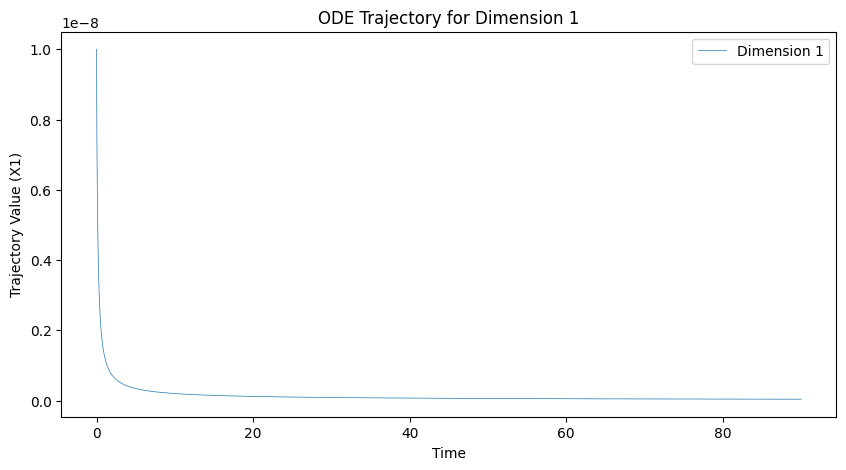

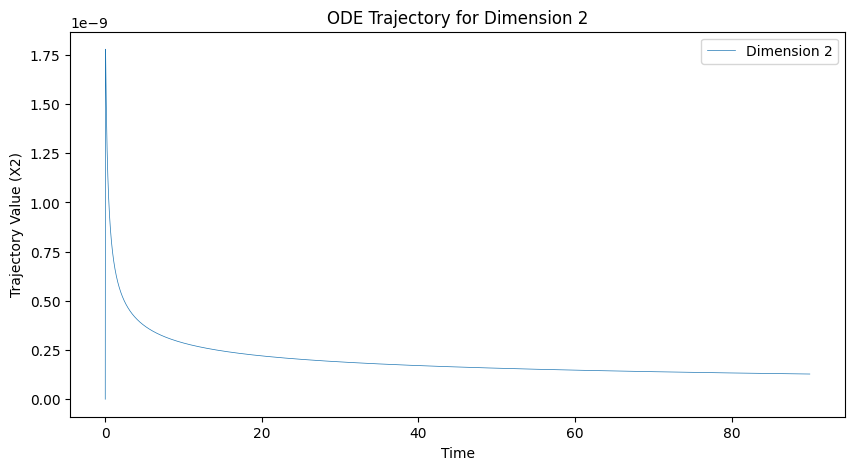

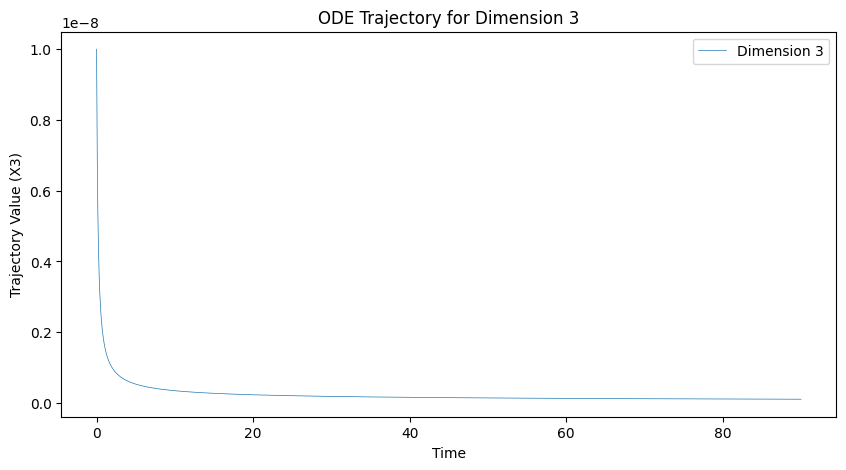

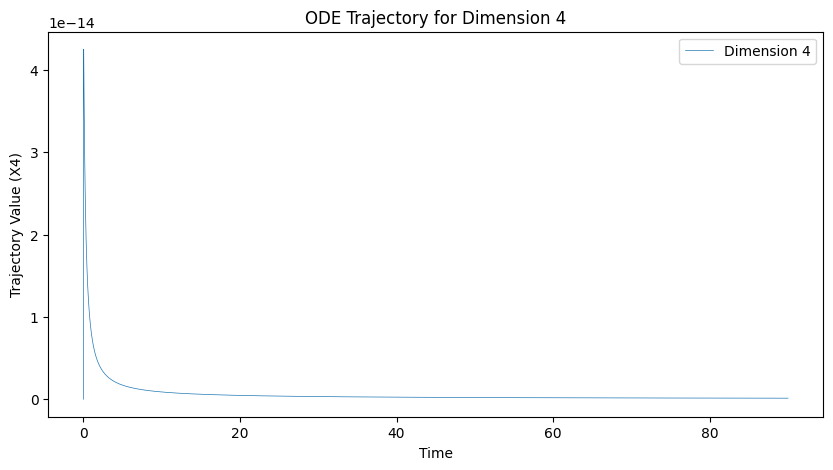

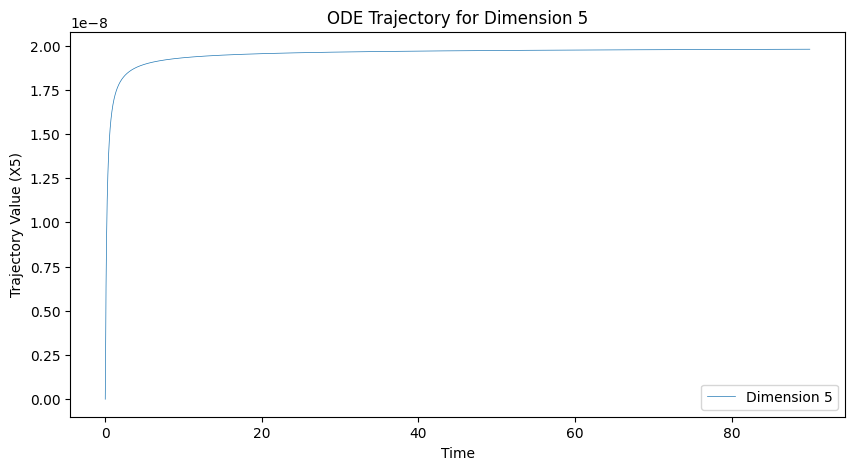

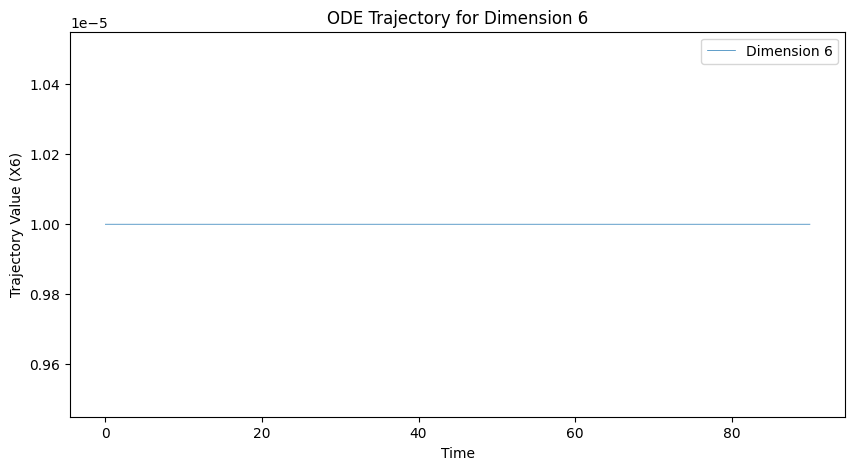

In [30]:
import matplotlib.pyplot as plt

for i in range(X.shape[1]):
    plt.figure(figsize=(10, 5))
    # plt.plot(t_train, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.plot(data.t, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.xlabel("Time")
    plt.ylabel(f"Trajectory Value (X{i+1})")
    plt.title(f"ODE Trajectory for Dimension {i+1}")
    plt.legend()
    plt.show()

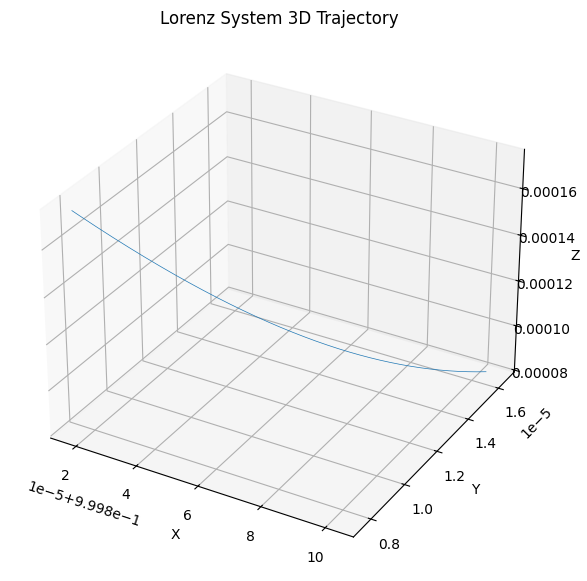

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz System 3D Trajectory")
plt.show()

In [7]:
# hydrogen_bromine(t_train, X.T), t_train.shape, X.shape
# for row in hydrogen_bromine(t_train, X.T):
#     print(len(row), row.shape)
# t_train.shape, X.shape

In [32]:
library = ps.PolynomialLibrary(degree=3)
library.fit(X)
true_coef = map_equation(hydrogen_bromine, library).T
model = ps.SINDy(
    feature_library=library,
    # optimizer=WeightedLasso(alpha=1e-4, weights=np.ones((library.size, 6)), max_iter=10000),
    optimizer=WeightedLasso(alpha=1e-4, weights=1/(np.abs(true_coef) + 1e-10), max_iter=10000),
    differentiation_method=ps.FiniteDifference(),
)


model.fit(x=X, t=t_train, x_dot=np.asarray(hydrogen_bromine(t_train, X.T)).T)
model.print()

Weighted L1 shape: (6,)
(x0)' = -117003107431205.219 x0 x3 + -625966.130 x0 x5 + 9494.375 x1 x4 + 14.975 x0 x3^2 + 0.001 x1^2 x3 + 1559940202213352.000 x1^2 x5 + -27.600 x1 x3^2 + -1.898 x2 x3^2 + 1293299.083 x3^3 + 2.728 x3^2 x4 + 0.001 x3^2 x5
(x1)' = 117013679882587.250 x0 x3 + 1251985.763 x0 x5 + -2610124882.332 x1 x2 + -7944.877 x1 x4 + 13903254561882.713 x3 x4 + 9.536 x0 x3^2 + -0.001 x1^2 x3 + -3120060317980748.500 x1^2 x5 + 66.896 x1 x3^2 + -2.909 x2 x3^2 + 828252.322 x3^3 + -12.195 x3^2 x4 + -0.002 x3^2 x5
(x2)' = -2610000000.000 x1 x2 + 13899999999998.477 x3 x4 + -6.988 x0 x3^2 + 4.089 x1 x3^2 + -8.957 x2 x3^2 + 1575953.315 x3^3 + -2.193 x3^2 x4
(x3)' = -117100572011934.000 x0 x3 + 2612242934.937 x1 x2 + 12819.036 x1 x4 + -13911907065105.443 x3 x4 + 6.286 x0 x3^2 + 0.001 x1^2 x3 + 20.360 x1 x3^2 + 6.273 x2 x3^2 + 3396421.309 x3^3 + 12.615 x3^2 x4 + 0.004 x3^2 x5
(x4)' = 116993963986985.203 x0 x3 + 2610135229.509 x1 x2 + -12808.345 x1 x4 + -13900757853622.881 x3 x4 + -15.355 x

In [33]:
print(ps.__version__)

2.0.0


In [34]:
library.n_output_features_

84

In [19]:
model.coefficients()

array([[-2.78828941e-35, -2.67374991e-20, -8.22679379e-27,
         4.98740407e-28, -3.72884678e-35, -8.22764807e-27,
         4.98827984e-28, -1.46946513e-21, -7.06787975e+02,
         5.82761545e-24,  8.97149679e-37, -8.23320447e-27,
         4.98375521e-28, -1.46971000e-21, -3.97906384e-27,
         5.82713069e-24, -1.67983812e-16, -6.17179869e-18,
         3.73992188e-19,  4.87869483e-20],
       [ 6.78197215e-36,  2.65878672e-23,  2.98078845e-29,
        -5.38016029e-30, -3.13875481e-35,  3.14784092e-29,
        -5.72210060e-30, -1.64304825e+03,  5.47628940e+01,
        -8.57988007e-26, -3.04437932e-35,  2.96858349e-29,
        -5.80682853e-30, -2.01064845e-25, -2.33709567e-27,
        -8.41154367e-26, -6.93294561e-19,  2.27202001e-20,
        -4.06608373e-21, -8.53859623e-22],
       [-7.07965295e-36, -1.05712436e-35, -7.97579948e-31,
         9.37055587e-32, -3.62925952e-36,  7.15909801e-31,
         1.62899845e-31,  9.62200404e+03,  2.21225602e-27,
         1.58649303e-28, -9.5

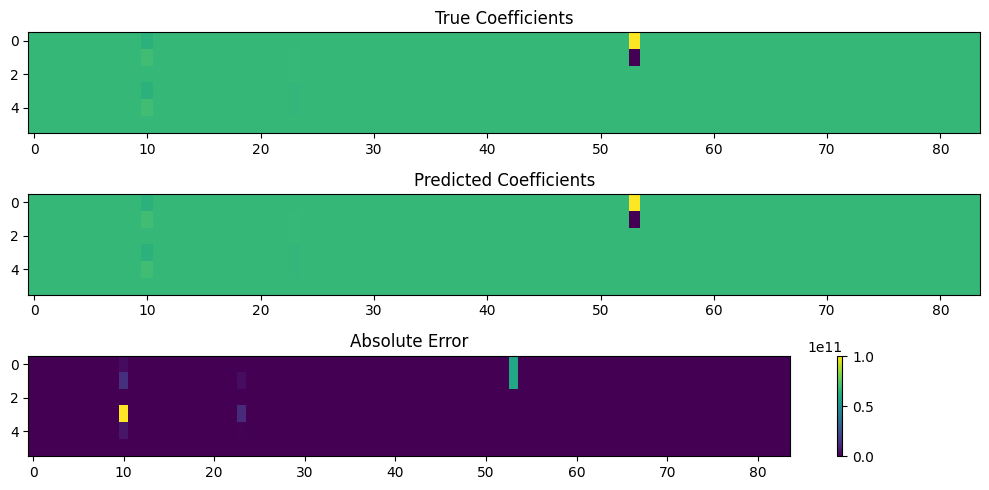

In [38]:
true_coef = map_equation(hydrogen_bromine, library)
pred_coef = model.coefficients()

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(true_coef, cmap='viridis', aspect='auto')
plt.title("True Coefficients")
plt.subplot(3, 1, 2)
plt.imshow(pred_coef, cmap='viridis', aspect='auto')
plt.title("Predicted Coefficients")
plt.subplot(3, 1, 3)
plt.imshow(np.abs(true_coef - pred_coef), cmap='viridis', aspect='auto')
plt.title("Absolute Error")
plt.colorbar()
plt.tight_layout()
plt.show()


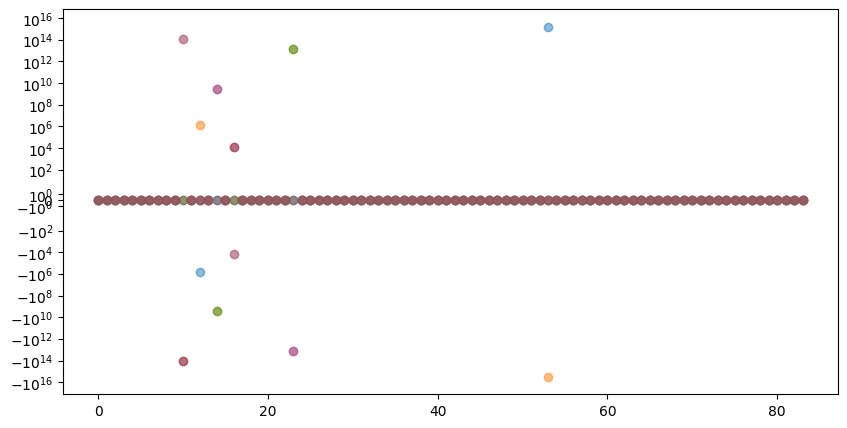

In [39]:
plt.figure(figsize=(10, 5))
for row in range(true_coef.shape[0]):
    plt.scatter(
        np.arange(true_coef.shape[1]),
        true_coef[row, :],
        label=f"True Coefficients Row {row}",
        alpha=0.5,
    )

plt.yscale('symlog')
plt.show()

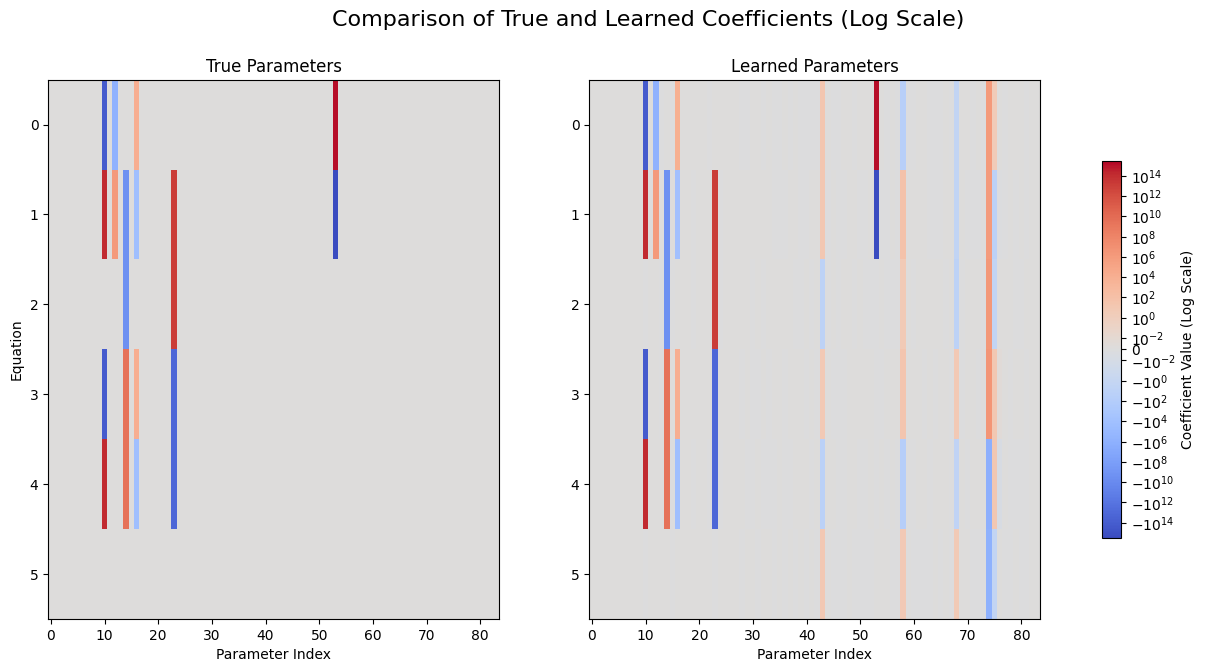

In [40]:
import matplotlib.colors as colors

# true_coef = map_equation(rober, library)
true_coef = map_equation(hydrogen_bromine, library)
# pred_coef = model.coefficients()

# plt.figure(figsize=(10, 5))
# plt.subplot(3, 1, 1)
# plt.imshow(true_coef, cmap='viridis', aspect='auto')
# plt.title("True Coefficients")
# plt.subplot(3, 1, 2)
# plt.imshow(pred_coef, cmap='viridis', aspect='auto')
# plt.title("Predicted Coefficients")
# plt.subplot(3, 1, 3)
# plt.imshow(np.abs(true_coef - pred_coef), cmap='viridis', aspect='auto')
# plt.title("Absolute Error")
# plt.colorbar()
# plt.tight_layout()
# plt.show()

learned_coefficients = model.coefficients()
# learned_coefficients[np.abs(learned_coefficients) < 1e-4] = 0.0
# true_parameters[np.abs(true_parameters) < 1e-4] = 0.0 # Also clean true params for fairness

# Reshape from 1D vector (100,) to 2D column vector (100, 1) for imshow
# true_params_2d = true_parameters.reshape(-1, 1)
# learned_coeffs_2d = learned_coefficients.reshape(-1, 1)


# --- 3. Set up Shared Color Scale ---
# Find the maximum absolute value across BOTH arrays to center the color map
abs_max = max(np.abs(true_coef).max(), np.abs(learned_coefficients).max())

# Set vmin and vmax to be symmetric around zero.
vmin = -abs_max
vmax = abs_max

# Create the symmetric log normalizer
# linthresh: The range within which the plot is linear (-linthresh to +linthresh)
# A smaller value makes the log scale apply to smaller numbers.
linthresh = 1e-2
log_norm = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10)


# --- 4. Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparison of True and Learned Coefficients (Log Scale)', fontsize=16)

# Plot True Parameters
im1 = ax[0].imshow(
    true_coef,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the shared log normalization
)
ax[0].set_title('True Parameters')
ax[0].set_xlabel('Parameter Index')
ax[0].set_ylabel('Equation')
# ax[0].set_xticks([]) # Hide x-axis ticks as they are not meaningful

# Plot Learned Parameters
im2 = ax[1].imshow(
    learned_coefficients,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the SAME shared log normalization
)
ax[1].set_title('Learned Parameters')
ax[1].set_xlabel('Parameter Index')
# ax[1].set_xticks([])
# ax[1].set_yticks([]) # Hide y-axis ticks for the second plot

# Add a single, shared colorbar
fig.colorbar(im2, ax=ax, orientation='vertical', label='Coefficient Value (Log Scale)', shrink=0.7)

# plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
# plt.show()
# plt.savefig('true_vs_learned_coefficients.png')

In [41]:
simulated_data = model.simulate(X[0], t_train)

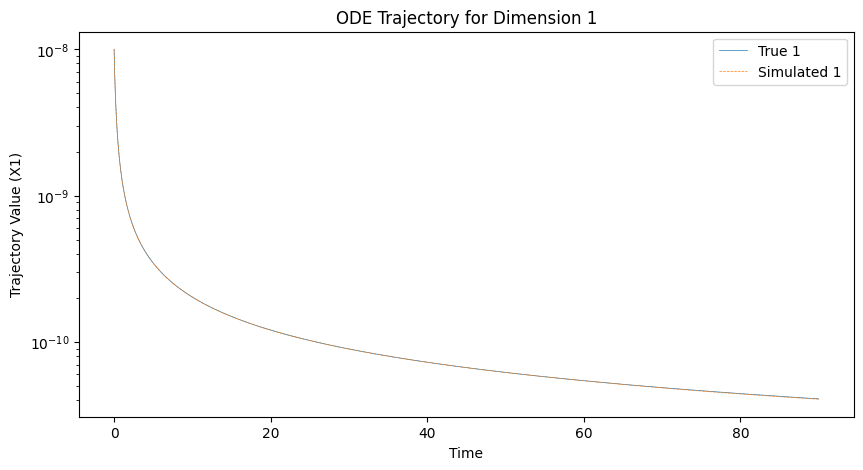

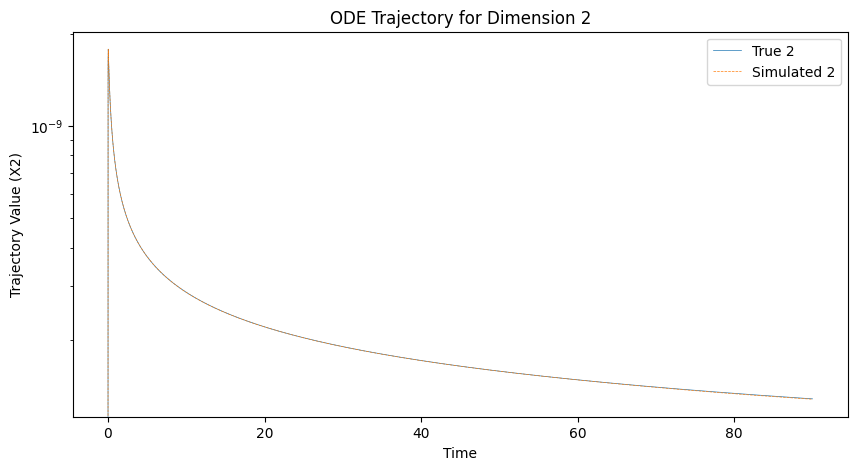

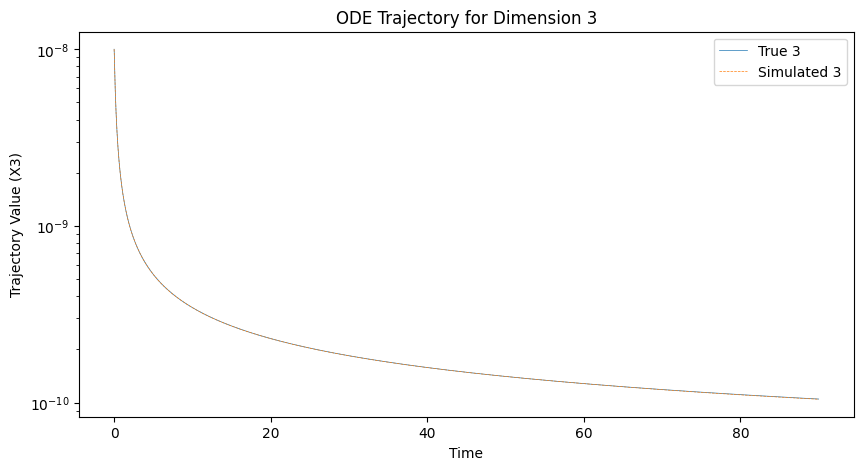

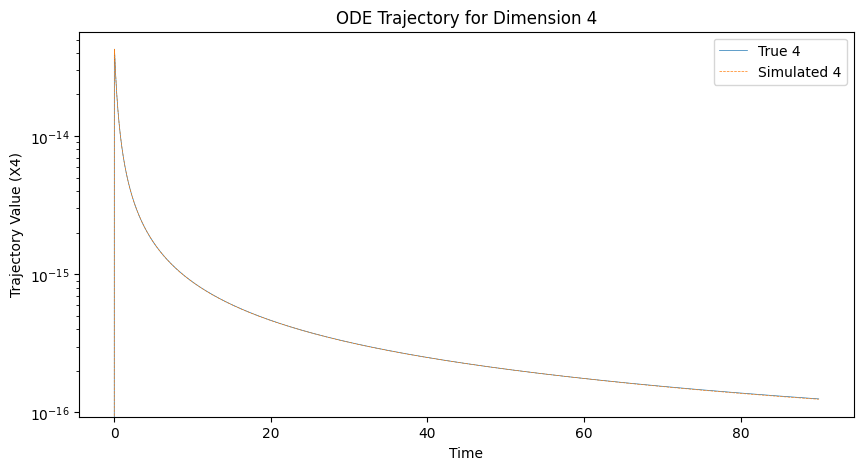

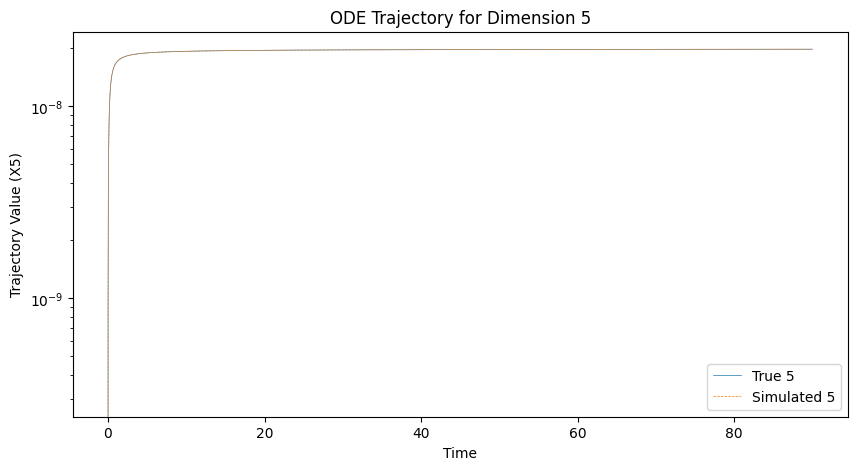

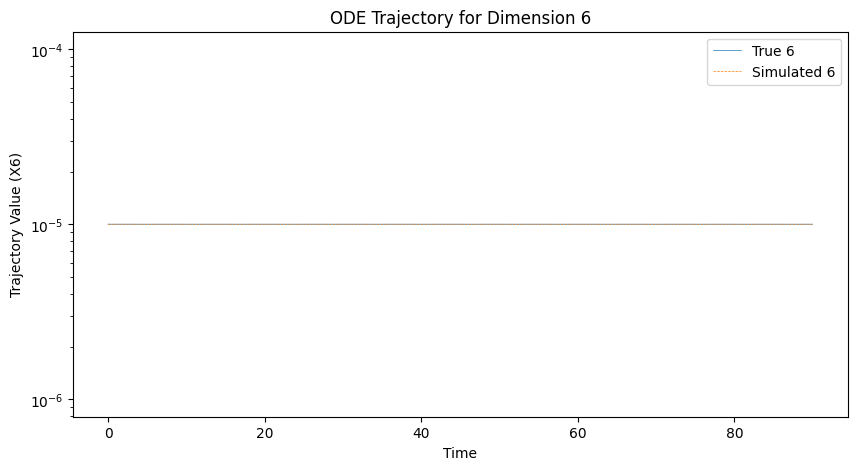

In [42]:
for i in range(X.shape[1]):
    plt.figure(figsize=(10, 5))
    # plt.plot(t_train, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.plot(data.t, X[:, i], label=f"True {i+1}", lw=0.5)
    plt.plot(t_train, simulated_data[:, i], label=f"Simulated {i+1}", lw=0.5, linestyle='--')
    plt.xlabel("Time")
    plt.ylabel(f"Trajectory Value (X{i+1})")
    plt.yscale('log')  # Use log scale for better visibility
    plt.title(f"ODE Trajectory for Dimension {i+1}")
    plt.legend()
    # plt.show()
    plt.savefig(f'trajectory_dimension_{i+1}.png')